## Step 0: Import Required Libraries

In [1]:
import os
import sys
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn.functional as F
from pathlib import Path

# Add parent directory to path
parent_dir = Path(os.getcwd()).parent
sys.path.insert(0, str(parent_dir))
sys.path.insert(0, str(parent_dir / 'word_segmentation'))
sys.path.insert(0, str(parent_dir / 'gpt-2-train'))

print("✓ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")

✓ Libraries imported successfully
TensorFlow version: 2.20.0
PyTorch version: 2.9.1


## Step 1: Load Word Segmentation Module

We'll use the `WordSegmenter` class to detect and extract bounding boxes around individual words.

In [2]:
# Import word segmentation module
from segmenter import WordSegmenter

# Initialize the word segmenter with default parameters
word_segmenter = WordSegmenter(
    blur_kernel=(3, 3),
    blur_sigma=1,
    morph_kernel=(3, 3),
    dilation_kernel=(1, 3),
    min_width=15,
    min_height=10,
    max_width_ratio=0.9,
    max_height_ratio=0.5,
    min_fill_ratio=0.1
)

print("✓ Word Segmenter initialized successfully")

✓ Word Segmenter initialized successfully


## Step 2: Load OCR Model and Encoder

We'll load the trained HTR model from the `ocr_weights` directory.

In [3]:
# Define Character Encoder class
class CharacterEncoder:
    """Encode and decode characters for model training/inference"""
    
    def __init__(self, characters=None):
        if characters is None:
            # Default character set
            self.characters = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,!?'-"
        else:
            self.characters = characters
        
        # Create character to index mapping
        self.char_to_num = {char: idx for idx, char in enumerate(self.characters)}
        
        # Create index to character mapping
        self.num_to_char = {idx: char for char, idx in self.char_to_num.items()}
        
        # Vocab size includes all characters + blank token
        self.vocab_size = len(self.characters) + 1
        self.blank_token_idx = len(self.characters)
    
    def encode(self, text):
        """Encode text to numerical indices"""
        encoded = []
        for char in text:
            if char in self.char_to_num:
                encoded.append(self.char_to_num[char])
        return encoded
    
    def decode(self, indices):
        """Decode numerical indices to text"""
        decoded = []
        for idx in indices:
            if idx < len(self.characters) and idx in self.num_to_char:
                decoded.append(self.num_to_char[idx])
        return ''.join(decoded)

# Initialize encoder
encoder = CharacterEncoder()
print(f"✓ Character Encoder initialized (vocab size: {encoder.vocab_size})")

✓ Character Encoder initialized (vocab size: 70)


In [20]:
# Build the CRNN model architecture
def build_crnn_model(input_shape=(32, 128, 1), num_classes=79):
    """Build CRNN model architecture for HTR"""
    from tensorflow.keras import layers, Model
    
    # Input layer
    input_layer = layers.Input(shape=input_shape, name='input_1')
    
    # Convolutional Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d')(input_layer)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d')(x)
    
    # Convolutional Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_1')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)
    
    # Convolutional Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_2')(x)
    
    # Convolutional Block 4
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_3')(x)
    x = layers.MaxPooling2D((2, 1), name='max_pooling2d_2')(x)
    
    # Convolutional Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_4')(x)
    x = layers.BatchNormalization(name='batch_normalization')(x)
    
    # Convolutional Block 6
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_5')(x)
    x = layers.BatchNormalization(name='batch_normalization_1')(x)
    x = layers.MaxPooling2D((2, 1), name='max_pooling2d_3')(x)
    
    # Convolutional Block 7
    x = layers.Conv2D(512, (2, 2), activation='relu', name='conv2d_6')(x)
    
    # Reshape for LSTM - use Reshape instead of Lambda to avoid serialization issues
    x = layers.Reshape(target_shape=(x.shape[2], x.shape[3]), name='reshape')(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2), 
                            name='bidirectional')(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2), 
                            name='bidirectional_1')(x)
    
    # Dense output layer
    output = layers.Dense(num_classes, activation='softmax', name='dense')(x)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output, name='CRNN_HTR')
    
    return model

print("✓ Model architecture function defined")

# Configure TensorFlow memory settings
import tensorflow as tf
tf.config.set_soft_device_placement(True)

# Limit GPU memory growth if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU configuration note: {e}")

# Build the model first (simpler approach)
print("\nBuilding OCR model architecture...")
ocr_model = build_crnn_model(input_shape=(32, 128, 1), num_classes=encoder.vocab_size)
print("✓ Model architecture built")

# Now try to load weights
ocr_model_path = parent_dir / 'ocr_weights' / 'htr_model_20251020_084444_base.h5'

print(f"\nLoading weights from: {ocr_model_path.name}")

try:
    # Simple approach: just load weights with skip_mismatch
    ocr_model.load_weights(str(ocr_model_path), skip_mismatch=True, by_name=False)
    print("✓ Weights loaded successfully")
except Exception as e:
    print(f"⚠ Weight loading issue: {str(e)[:150]}")
    print("\nNote: Model will use random initialization.")
    print("For best results, ensure the weight file matches the model architecture.")

# Display model info
print(f"\n{'='*60}")
print("OCR Model Information:")
print(f"{'='*60}")
print(f"  Input shape:  {ocr_model.input_shape}")
print(f"  Output shape: {ocr_model.output_shape}")
print(f"  Parameters:   {ocr_model.count_params():,}")
print(f"{'='*60}")
print("✓ OCR model ready for inference")

✓ Model architecture function defined

Building OCR model architecture...
✓ Model architecture built

Loading weights from: htr_model_20251020_084444_base.h5
✓ Weights loaded successfully

OCR Model Information:
  Input shape:  (None, 32, 128, 1)
  Output shape: (None, 31, 70)
  Parameters:   8,738,630
✓ OCR model ready for inference


/Users/raghav_sarna/Desktop/Drive/Plaksha/Semester 5/DL/handwriting/.venv/lib/python3.13/site-packages/keras/src/legacy/saving/legacy_h5_format.py:385: UserWarning: Skipping loading weights for layer #11 (named dense)due to mismatch in shape for weight dense/kernel. Weight expects shape (512, 70). Received saved weight with shape (512, 78)
  _set_weights(
/Users/raghav_sarna/Desktop/Drive/Plaksha/Semester 5/DL/handwriting/.venv/lib/python3.13/site-packages/keras/src/legacy/saving/legacy_h5_format.py:385: UserWarning: Skipping loading weights for layer #11 (named dense)due to mismatch in shape for weight dense/bias. Weight expects shape (70,). Received saved weight with shape (78,)
  _set_weights(


## Step 3: Load GPT-2 Model for Next Word Prediction

We'll load the fine-tuned GPT-2 model from the checkpoint.

In [7]:
# Import GPT-2 model and tokenizer
from model import GPT, GPTConfig
import tiktoken

# Set device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = 'mps'
print(f"Using device: {device}")

Using device: mps


In [8]:
# Load GPT-2 from pretrained weights (using TensorFlow checkpoint)
import json

# Read hparams
hparams_path = parent_dir / 'gpt-2-124M_checkpoints' / 'hparams.json'
with open(hparams_path, 'r') as f:
    hparams = json.load(f)

print("GPT-2 Hyperparameters:")
for key, value in hparams.items():
    print(f"  {key}: {value}")

# Create GPT config
gpt_config = GPTConfig(
    context_length=hparams['n_ctx'],
    vocab_size=hparams['n_vocab'],
    num_layers=hparams['n_layer'],
    embd_size=hparams['n_embd'],
    num_heads=hparams['n_head']
)

print("\n✓ GPT-2 config created")

GPT-2 Hyperparameters:
  n_vocab: 50257
  n_ctx: 1024
  n_embd: 768
  n_head: 12
  n_layer: 12

✓ GPT-2 config created


In [11]:
# Load GPT-2 model from pretrained weights
print("Loading GPT-2 model...")
gpt_model = GPT.from_pretrained('gpt2')
gpt_model = gpt_model.to(device)
gpt_model.eval()

# Load tokenizer
tokenizer = tiktoken.get_encoding('gpt2')

print("✓ GPT-2 model loaded successfully")
print(f"  Config: {gpt_config.num_layers} layers, {gpt_config.embd_size} embedding size")
print(f"  Vocab size: {gpt_config.vocab_size}")

Loading GPT-2 model...


/Users/raghav_sarna/Desktop/Drive/Plaksha/Semester 5/DL/handwriting/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2
✓ GPT-2 model loaded successfully
  Config: 12 layers, 768 embedding size
  Vocab size: 50257
✓ GPT-2 model loaded successfully
  Config: 12 layers, 768 embedding size
  Vocab size: 50257


## Step 4: Define Helper Functions

These functions will handle image preprocessing and text generation.

In [12]:
# OCR Preprocessing Functions
def preprocess_word_for_ocr(word_image, target_height=32, target_width=128):
    """Preprocess a word image for OCR recognition"""
    # Convert to grayscale if needed
    if len(word_image.shape) == 3:
        gray = cv2.cvtColor(word_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = word_image
    
    # Apply Otsu thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Resize with padding
    h, w = binary.shape[:2]
    scale = min(target_height / h, target_width / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create padded image
    padded = np.ones((target_height, target_width), dtype=np.uint8) * 255
    y_offset = (target_height - new_h) // 2
    x_offset = (target_width - new_w) // 2
    padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    # Normalize
    normalized = padded.astype(np.float32) / 255.0
    
    # Add channel dimension
    preprocessed = np.expand_dims(normalized, axis=-1)
    
    return preprocessed

def decode_ocr_predictions(predictions, encoder):
    """Decode CTC predictions to text"""
    batch_size = predictions.shape[0]
    time_steps = predictions.shape[1]
    
    # Create input_length for all samples
    input_lengths = np.full((batch_size,), time_steps, dtype=np.int32)
    
    # Decode using CTC
    decoded, _ = tf.keras.backend.ctc_decode(
        predictions,
        input_length=input_lengths,
        greedy=True
    )
    
    # Convert to text
    decoded_texts = []
    decoded = decoded[0].numpy()
    for i in range(batch_size):
        seq = decoded[i]
        text = encoder.decode(seq)
        decoded_texts.append(text)
    
    return decoded_texts

print("✓ OCR helper functions defined")

✓ OCR helper functions defined


In [13]:
# GPT-2 Generation Function
def generate_next_words(prompt, num_predictions=3, max_new_tokens=5, temperature=1.0, top_k=50):
    """Generate next word predictions using GPT-2"""
    gpt_model.eval()
    
    # Encode prompt
    tokens = tokenizer.encode(prompt)
    idx = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    
    # Clamp to context length
    context_len = gpt_model.config.context_length
    if idx.shape[1] > context_len:
        idx = idx[:, -context_len:]
    
    # Generate
    with torch.no_grad():
        logits, _ = gpt_model(idx)
        logits = logits[:, -1, :]  # Get last token logits
        
        if temperature != 1.0:
            logits = logits / max(temperature, 1e-5)
        
        # Get top-k predictions
        topk_vals, topk_idx = torch.topk(logits, k=min(top_k, logits.shape[-1]), dim=-1)
        probs = F.softmax(topk_vals, dim=-1)
        
        # Get top N predictions
        top_n_probs, top_n_indices = torch.topk(probs, k=min(num_predictions, probs.shape[-1]), dim=-1)
        top_n_tokens = torch.gather(topk_idx, -1, top_n_indices)
        
        # Decode tokens
        predictions = []
        for i in range(top_n_tokens.shape[1]):
            token_id = top_n_tokens[0, i].item()
            token_text = tokenizer.decode([token_id])
            prob = top_n_probs[0, i].item()
            predictions.append((token_text, prob))
    
    return predictions

print("✓ GPT-2 generation function defined")

✓ GPT-2 generation function defined


## Step 5: Complete Pipeline Function

This function ties everything together: segmentation → OCR → next word prediction.

In [14]:
def complete_pipeline(image_path, visualize=True, num_predictions=5):
    """
    Complete pipeline: Word Segmentation → OCR → Next Word Prediction
    
    Args:
        image_path: Path to input handwritten text image
        visualize: Whether to show visualizations
        num_predictions: Number of next word predictions to generate
    
    Returns:
        Dictionary containing results from each step
    """
    results = {}
    
    # ========== STEP 1: WORD SEGMENTATION ==========
    print("\n" + "="*60)
    print("STEP 1: WORD SEGMENTATION")
    print("="*60)
    
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    print(f"Image loaded: {image.shape}")
    
    # Segment words
    seg_results = word_segmenter.segment(image)
    boxes = seg_results['boxes']
    word_images = seg_results['word_images']
    image_with_boxes = seg_results['image_with_boxes']
    
    print(f"Found {len(boxes)} words")
    print(f"Organized into {seg_results['num_lines']} lines")
    
    results['segmentation'] = seg_results
    
    # Visualize segmentation
    if visualize and len(boxes) > 0:
        plt.figure(figsize=(15, 8))
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title(f"Word Segmentation Result ({len(boxes)} words detected)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Show first few segmented words
        if len(word_images) > 0:
            num_show = min(8, len(word_images))
            fig, axes = plt.subplots(2, 4, figsize=(15, 6))
            axes = axes.flatten()
            for i in range(num_show):
                axes[i].imshow(cv2.cvtColor(word_images[i], cv2.COLOR_BGR2RGB))
                axes[i].set_title(f"Word {i+1}")
                axes[i].axis('off')
            for i in range(num_show, 8):
                axes[i].axis('off')
            plt.suptitle("Sample Segmented Words")
            plt.tight_layout()
            plt.show()
    
    # ========== STEP 2: OCR RECOGNITION ==========
    print("\n" + "="*60)
    print("STEP 2: OCR RECOGNITION")
    print("="*60)
    
    recognized_words = []
    
    if len(word_images) > 0:
        # Preprocess all word images
        preprocessed_words = []
        for word_img in word_images:
            preprocessed = preprocess_word_for_ocr(word_img)
            preprocessed_words.append(preprocessed)
        
        # Batch prediction
        batch = np.array(preprocessed_words)
        print(f"Processing batch of {len(batch)} words...")
        
        predictions = ocr_model.predict(batch, verbose=0)
        recognized_words = decode_ocr_predictions(predictions, encoder)
        
        print(f"\nRecognized words:")
        for i, word in enumerate(recognized_words, 1):
            print(f"  {i}. '{word}'")
        
        # Combine into full text
        full_text = ' '.join(recognized_words)
        print(f"\nFull recognized text: '{full_text}'")
        
        results['ocr'] = {
            'words': recognized_words,
            'full_text': full_text
        }
    else:
        print("No words detected to recognize")
        results['ocr'] = {'words': [], 'full_text': ''}
        full_text = ''
    
    # ========== STEP 3: NEXT WORD PREDICTION ==========
    print("\n" + "="*60)
    print("STEP 3: NEXT WORD PREDICTION")
    print("="*60)
    
    if full_text:
        print(f"Generating next word predictions for: '{full_text}'")
        
        # Generate predictions
        predictions = generate_next_words(
            prompt=full_text,
            num_predictions=num_predictions,
            temperature=1.0,
            top_k=50
        )
        
        print(f"\nTop {len(predictions)} next word predictions:")
        for i, (word, prob) in enumerate(predictions, 1):
            print(f"  {i}. '{word}' (probability: {prob:.4f})")
        
        results['gpt2'] = {
            'predictions': predictions,
            'prompt': full_text
        }
        
        # Visualize predictions
        if visualize:
            words, probs = zip(*predictions)
            plt.figure(figsize=(12, 6))
            plt.barh(range(len(words)), probs, color='steelblue')
            plt.yticks(range(len(words)), [f"'{w}'" for w in words])
            plt.xlabel('Probability')
            plt.title(f'Top {len(predictions)} Next Word Predictions')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
    else:
        print("No text recognized, skipping next word prediction")
        results['gpt2'] = {'predictions': [], 'prompt': ''}
    
    # ========== SUMMARY ==========
    print("\n" + "="*60)
    print("PIPELINE SUMMARY")
    print("="*60)
    print(f"Words detected: {len(boxes)}")
    print(f"Words recognized: {len(recognized_words)}")
    print(f"Recognized text: '{full_text}'")
    if results['gpt2']['predictions']:
        top_pred = results['gpt2']['predictions'][0]
        print(f"Top next word prediction: '{top_pred[0]}' (prob: {top_pred[1]:.4f})")
    print("="*60)
    
    return results

print("✓ Complete pipeline function defined")

✓ Complete pipeline function defined


## Step 6: Test the Pipeline

Now let's test the complete pipeline on a sample image.

In [15]:
# Test with a sample image
# Replace this path with your actual test image path
test_image_path = '../test_sentence.jpg'  # Modify this path

# Check if file exists
if os.path.exists(test_image_path):
    print(f"Testing pipeline with image: {test_image_path}")
    results = complete_pipeline(
        image_path=test_image_path,
        visualize=True,
        num_predictions=5
    )
else:
    print(f"Test image not found at: {test_image_path}")
    print("Please provide a valid image path in the cell above.")
    print("\nYou can also use cv2.imread() to load an image from any location.")

Test image not found at: ../test_sentence.jpg
Please provide a valid image path in the cell above.

You can also use cv2.imread() to load an image from any location.


## Step 7: Interactive Testing

Test the pipeline with your own images.

In [16]:
# Interactive function to test with custom images
def test_custom_image(image_path):
    """
    Test the pipeline with a custom image path
    
    Usage:
        test_custom_image('/path/to/your/image.jpg')
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None
    
    return complete_pipeline(
        image_path=image_path,
        visualize=True,
        num_predictions=5
    )

# Example usage:
# results = test_custom_image('/path/to/your/handwritten/text.jpg')

print("✓ Interactive testing function ready")
print("\nUsage: test_custom_image('/path/to/your/image.jpg')")

✓ Interactive testing function ready

Usage: test_custom_image('/path/to/your/image.jpg')


## Step 8: Individual Component Testing

Test each component separately for debugging or experimentation.

In [17]:
# Test individual components

# 1. Test Word Segmentation only
def test_segmentation(image_path):
    image = cv2.imread(image_path)
    results = word_segmenter.segment(image)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(results['image_with_boxes'], cv2.COLOR_BGR2RGB))
    plt.title(f"Detected {results['num_words']} words")
    plt.axis('off')
    plt.show()
    
    return results

# 2. Test OCR only (requires preprocessed word image)
def test_ocr(word_image):
    preprocessed = preprocess_word_for_ocr(word_image)
    batch = np.expand_dims(preprocessed, axis=0)
    prediction = ocr_model.predict(batch, verbose=0)
    text = decode_ocr_predictions(prediction, encoder)[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].imshow(word_image if len(word_image.shape) == 2 else cv2.cvtColor(word_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Word')
    axes[0].axis('off')
    
    axes[1].imshow(preprocessed.squeeze(), cmap='gray')
    axes[1].set_title(f'Preprocessed (Recognized: "{text}")')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    return text

# 3. Test GPT-2 only
def test_gpt2(prompt, num_predictions=5):
    predictions = generate_next_words(prompt, num_predictions=num_predictions)
    
    print(f"Prompt: '{prompt}'")
    print(f"\nTop {len(predictions)} predictions:")
    for i, (word, prob) in enumerate(predictions, 1):
        print(f"  {i}. '{word}' (prob: {prob:.4f})")
    
    words, probs = zip(*predictions)
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(words)), probs, color='steelblue')
    plt.yticks(range(len(words)), [f"'{w}'" for w in words])
    plt.xlabel('Probability')
    plt.title(f'Next Word Predictions for: "{prompt}"')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return predictions

print("✓ Individual testing functions defined")
print("\nAvailable functions:")
print("  - test_segmentation(image_path)")
print("  - test_ocr(word_image)")
print("  - test_gpt2(prompt, num_predictions=5)")

✓ Individual testing functions defined

Available functions:
  - test_segmentation(image_path)
  - test_ocr(word_image)
  - test_gpt2(prompt, num_predictions=5)


## Example: Test Individual Components

Prompt: 'The quick brown fox'

Top 5 predictions:
  1. 'es' (prob: 0.2408)
  2. ' was' (prob: 0.0848)
  3. ' is' (prob: 0.0639)
  4. ''s' (prob: 0.0616)
  5. ',' (prob: 0.0581)


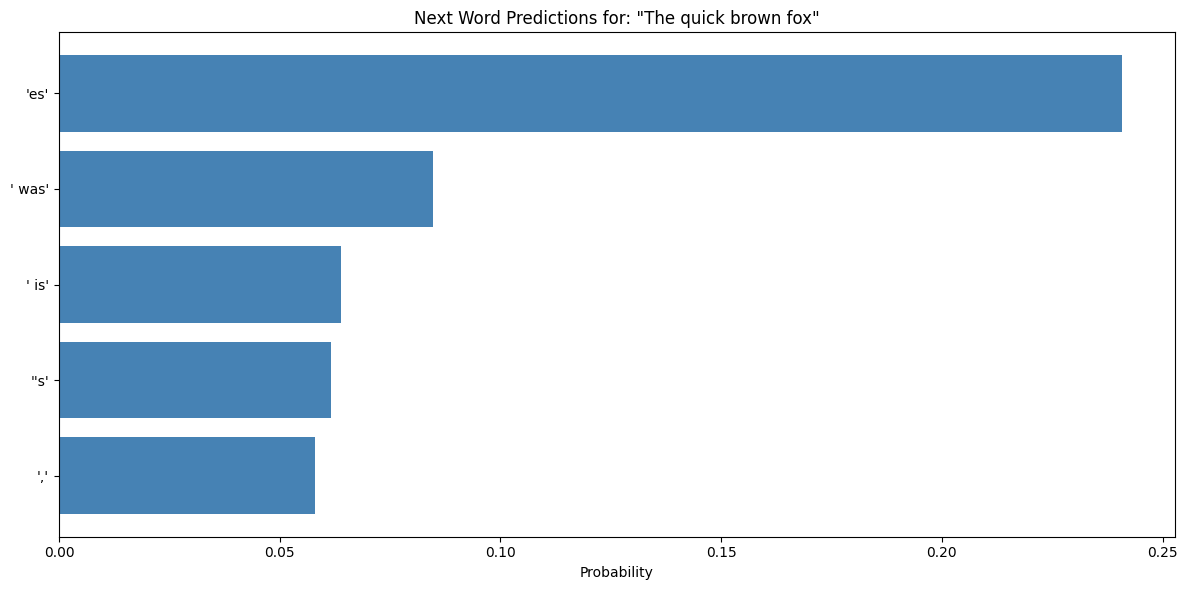

In [18]:
# Example: Test GPT-2 with custom text
test_prompt = "The quick brown fox"
gpt2_results = test_gpt2(test_prompt, num_predictions=5)

Running complete pipeline on: handwriting.png

STEP 1: WORD SEGMENTATION
Image loaded: (180, 466, 3)
Found 7 words
Organized into 1 lines


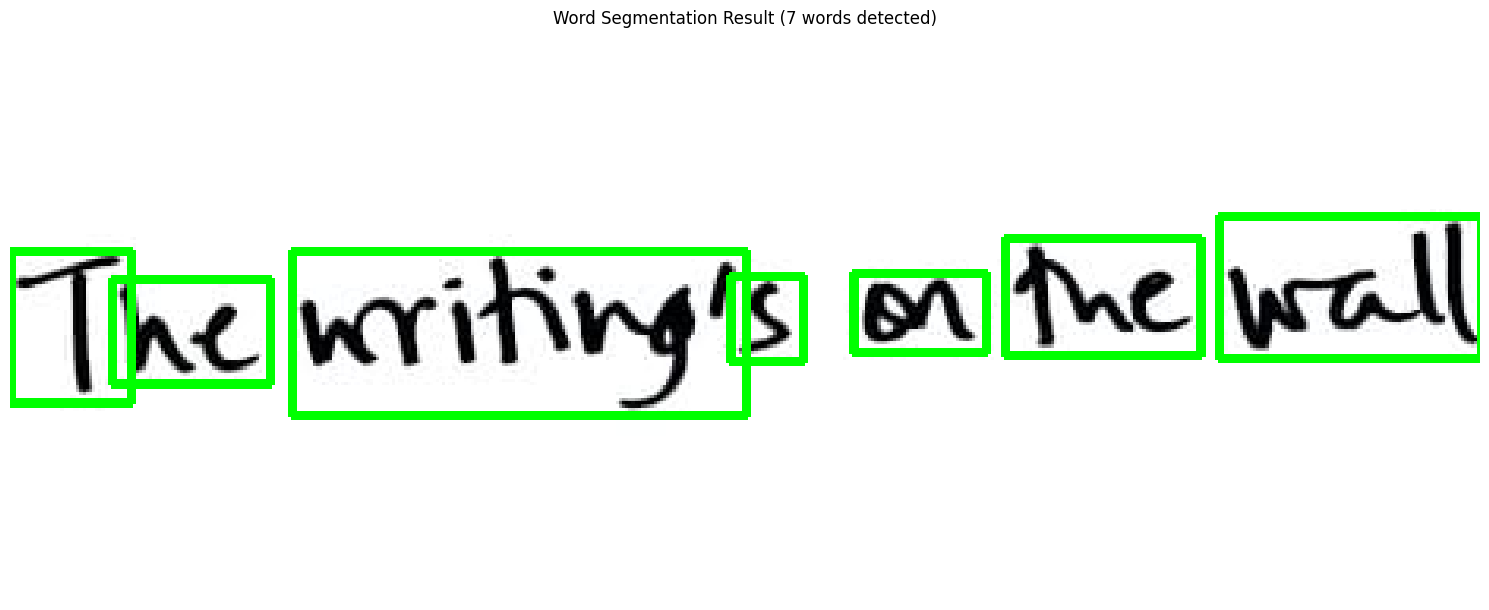

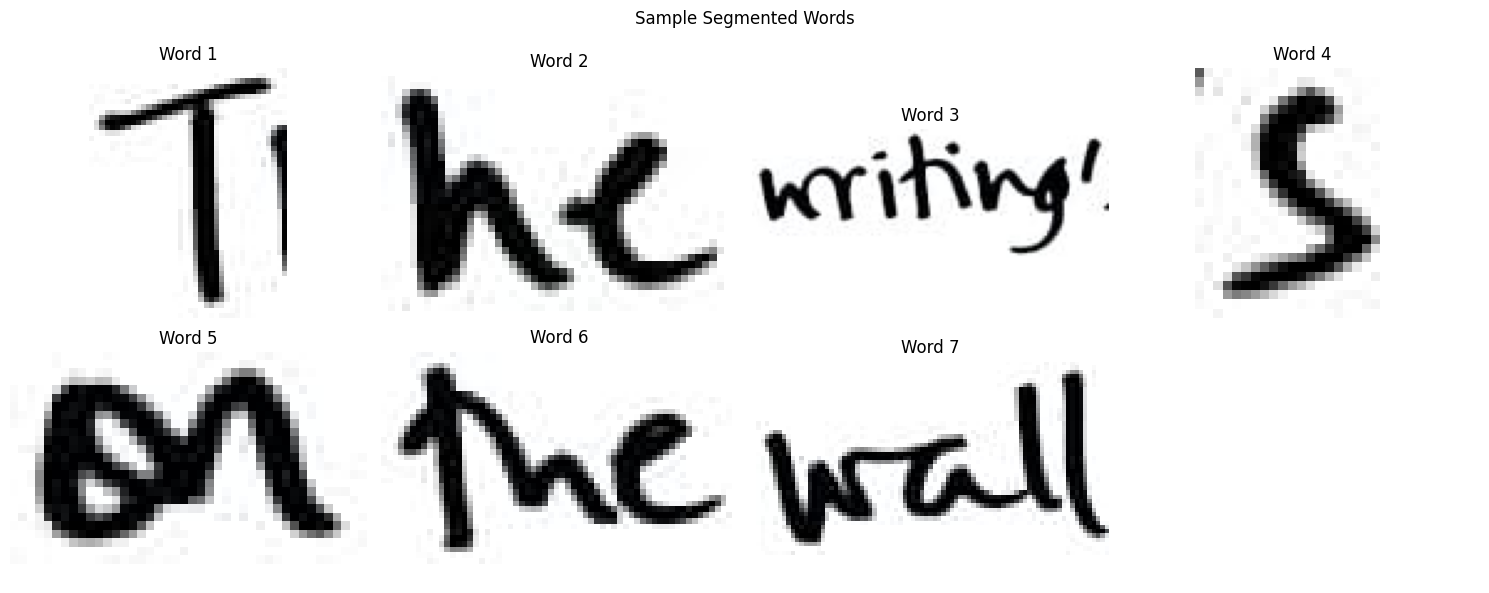


STEP 2: OCR RECOGNITION
Processing batch of 7 words...

Recognized words:
  1. 'VhdQdGdvDcXz'
  2. 'Ye,G42F2DPcKd'
  3. ''g4,DJ'D'DUT-UkR!p'
  4. 'S7cQKQ7KDd4thdtU'
  5. '17mKxtx'X56wM'
  6. 'uea42D2PdxdPcx!K'
  7. 'FvvFqXFD1jPC5cdku'

Full recognized text: 'VhdQdGdvDcXz Ye,G42F2DPcKd 'g4,DJ'D'DUT-UkR!p S7cQKQ7KDd4thdtU 17mKxtx'X56wM uea42D2PdxdPcx!K FvvFqXFD1jPC5cdku'

STEP 3: NEXT WORD PREDICTION
Generating next word predictions for: 'VhdQdGdvDcXz Ye,G42F2DPcKd 'g4,DJ'D'DUT-UkR!p S7cQKQ7KDd4thdtU 17mKxtx'X56wM uea42D2PdxdPcx!K FvvFqXFD1jPC5cdku'

Top 10 next word predictions:
  1. 'U' (probability: 0.0364)
  2. '9' (probability: 0.0342)
  3. 'X' (probability: 0.0324)
  4. '8' (probability: 0.0320)
  5. 'Z' (probability: 0.0319)
  6. 'Y' (probability: 0.0306)
  7. 'C' (probability: 0.0289)
  8. 'Q' (probability: 0.0284)
  9. 'q' (probability: 0.0276)
  10. 'D' (probability: 0.0273)

Top 10 next word predictions:
  1. 'U' (probability: 0.0364)
  2. '9' (probability: 0.0342)
  3. 'X' (

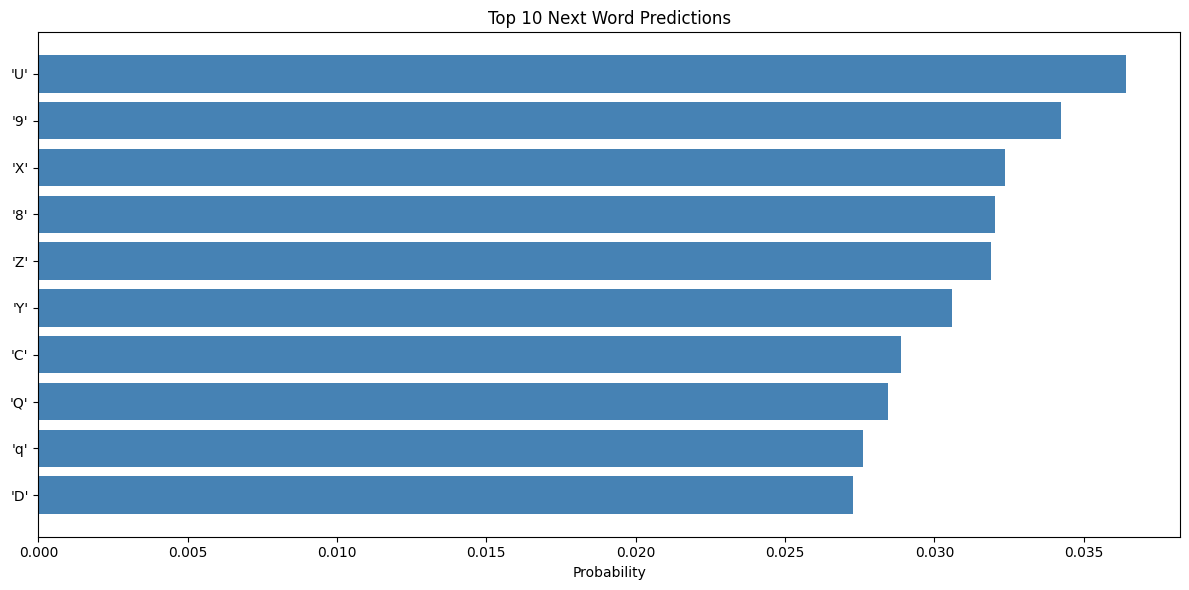


PIPELINE SUMMARY
Words detected: 7
Words recognized: 7
Recognized text: 'VhdQdGdvDcXz Ye,G42F2DPcKd 'g4,DJ'D'DUT-UkR!p S7cQKQ7KDd4thdtU 17mKxtx'X56wM uea42D2PdxdPcx!K FvvFqXFD1jPC5cdku'
Top next word prediction: 'U' (prob: 0.0364)


In [24]:
# Run pipeline on handwriting.png
image_path = 'handwriting.png'

print(f"Running complete pipeline on: {image_path}")
print("="*80)

# Execute the pipeline with full visualization
results = complete_pipeline(
    image_path=image_path,
    visualize=True,
    num_predictions=10  # Get top 10 next word predictions
)

## Run Complete Pipeline on handwriting.png

Let's run the full pipeline on the handwriting.png image in this directory.

---

## Pipeline Complete!

You now have a fully integrated pipeline that:
1. ✓ Segments handwritten text into individual words using bounding boxes
2. ✓ Recognizes each word using a trained OCR model
3. ✓ Predicts the next word using GPT-2

### Next Steps:
- Test with your own handwritten text images
- Adjust segmentation parameters if needed
- Fine-tune GPT-2 parameters (temperature, top_k) for better predictions
- Experiment with different prompts and contexts

### Key Functions:
- `complete_pipeline(image_path, visualize=True, num_predictions=5)` - Full pipeline
- `test_custom_image(image_path)` - Quick test with custom image
- `test_segmentation(image_path)` - Test word segmentation only
- `test_ocr(word_image)` - Test OCR only
- `test_gpt2(prompt, num_predictions=5)` - Test GPT-2 only